# BenchMARL

[BenchMARL](https://benchmarl.readthedocs.io/en/latest/) implements several multi-agent RL algorithm, using the backbone of [Torch RL](https://docs.pytorch.org/rl/stable/index.html).

In this notebook, agents perceive relative position *and* speed, similar to :doc:`Distributed-SAC` but we use BenchMARL instead of StableBaseline3 to train a distibuited policy.

You can skip training and instead load the last trained policy by changing the flag below.

In [1]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings('ignore')

## Continuos actions with MASAC 

MASAC is a multi-agent version of SAC (off-policy). It learns a *centralized critic*, while keeping the policy decentralized. 

We start with a critic that takes the joint observation as input.

In [70]:
from navground.learning import DefaultObservationConfig, ControlActionConfig
from navground.learning.parallel_env import make_vec_from_penv
from navground.learning.examples.pad import get_env, marker, neighbor
from navground.learning.scenarios.pad import render_kwargs

name = "Distributed"
action = ControlActionConfig(use_acceleration_action=True, max_acceleration=1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, 
                                       include_target_direction=False, flat_values=True)
sensors = [marker(), neighbor()]
train_env = get_env(action=action, observation=observation, sensors=sensors, 
                    start_in_opposite_sides=False, 
                    include_success=True, init_success=False, intermediate_success=True
                    )
test_env = get_env(action=action, observation=observation, sensors=sensors, 
                   start_in_opposite_sides=True, 
                   include_success=True, init_success=False, intermediate_success=True, 
                   render_mode='rgb_array', render_kwargs=render_kwargs())

In [5]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [6]:
%%run_if $training

import os
from benchmarl.algorithms import MasacConfig
from benchmarl.models.mlp import MlpConfig
from benchmarl.experiment import ExperimentConfig
from navground.learning.utils.benchmarl import NavgroundExperiment, ExportPolicyCallback

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac.folder_name

PosixPath('logs/Distributed/MASAC/masac_navground_mlp__2399ac94_25_05_21-11_54_30')

In [7]:
%%run_if $training

experiment_masac.run_for(iterations=20)

mean return = -9.643845558166504: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:55<00:00, 23.76s/it]


We can evalute the policy directly using

In [8]:
experiment_masac.evaluate_policy(n_eval_episodes=30)

(-89.67737, 84.50013)

or we can construct a (single-agent) policy to be compatible with StableBaseline3, and then use their tools to evaluate it:

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy
from navground.learning.parallel_env import make_vec_from_penv

test_venv = make_vec_from_penv(test_env)
policy_masac = experiment_masac.get_single_agent_policy()
evaluate_policy(policy_masac, test_venv, n_eval_episodes=30)

(-108.53362036148707, 84.10392849743498)

We can also load the exported best policy:

In [10]:
policy_masac = experiment_masac.load_policy(name='best_policy')
evaluate_policy(policy_masac, test_venv, n_eval_episodes=30)

(-18.0316518565019, 19.151734483397266)

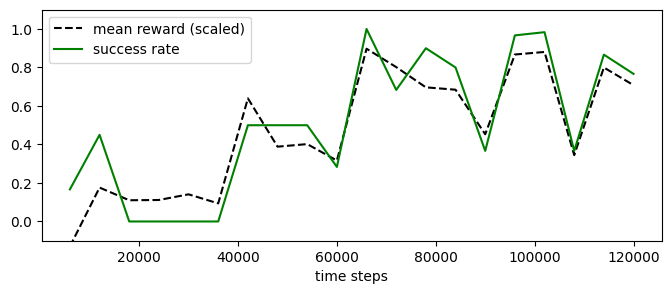

In [11]:
experiment_masac.plot_eval_logs(reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [12]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=policy_masac, factor=4, seed=1, **render_kwargs())

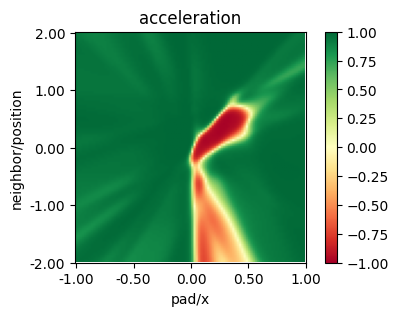

In [13]:
from navground.learning.utils.plot import plot_policy

plot_policy(policy_masac, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.1, 'neighbor/velocity': 0.1},
            actions={0: 'acceleration'}, width=5, height=3)

## MASAC with global state critic

In this second example, we use a critic that takes the global *state* of the multi-agent environment as input. In this case, as the observation are complete, we don't expect that using the state will have a large impact. It will instead have an impact in other notebook where observation are partial.

We configure the state to contain (horizontal) position and speed of both agents.

In [71]:
from navground.learning import DefaultStateConfig

state = DefaultStateConfig(include_y=False, include_position=True, include_velocity=True)
train_env_state = get_env(action=action, observation=observation, sensors=sensors, state=state,
                    start_in_opposite_sides=False, include_success=True, init_success=False, intermediate_success=True)
test_env_state = get_env(action=action, observation=observation, sensors=sensors, state=state,
                   start_in_opposite_sides=True, include_success=True, init_success=False, intermediate_success=True, 
                   render_mode='rgb_array', render_kwargs=render_kwargs())
train_env_state.state_space

Box([-1.   -1.   -0.14 -0.14], [1.   1.   0.14 0.14], (4,), float32)

In [15]:
%%skip_if $training

path = max(pathlib.Path(f'logs/{name}/MASAC-State').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment_masac_state = NavgroundExperiment.reload_from_file(str(path))
experiment_masac_state.folder_name

In [16]:
%%run_if $training

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC-State'
os.makedirs(config.save_folder, exist_ok=True)

experiment_masac_state = NavgroundExperiment(
    env=train_env_state,
    eval_env=test_env_state,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac_state.folder_name

PosixPath('logs/Distributed/MASAC-State/masac_navground_mlp__dcf869d3_25_05_21-12_02_37')

In [17]:
%%run_if $training

experiment_masac_state.run_for(iterations=20)

mean return = -3.12227725982666: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:30<00:00, 25.54s/it]


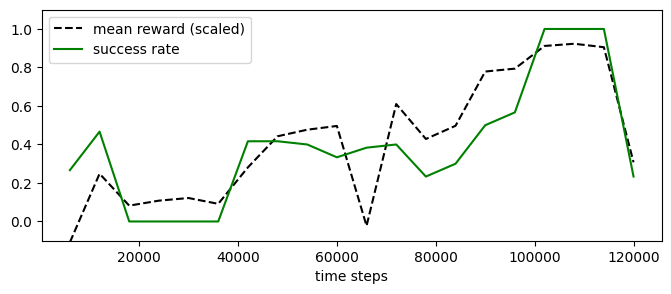

In [18]:
experiment_masac_state.plot_eval_logs(reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [19]:
policy_masac_state = experiment_masac_state.load_policy(name='best_policy')
evaluate_policy(policy_masac_state, test_venv, n_eval_episodes=30)

(-14.781858468055725, 16.883285865221644)

In [20]:
display_episode_video(test_env, policy=policy_masac_state, factor=4, seed=123, **render_kwargs())

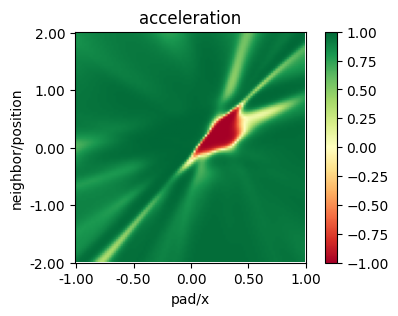

In [21]:
plot_policy(policy_masac_state, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.1, 'neighbor/velocity': 0.1},
            actions={0: 'acceleration'}, width=5, height=3)

## MAPPO

Mappo is a multi-agent variant of PPO (on-policy).

In [22]:
%%skip_if $training

path = max(pathlib.Path(f'logs/{name}/MAPPO').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment_mappo = NavgroundExperiment.reload_from_file(str(path))
experiment_mappo.folder_name

In [26]:
%%run_if $training

from benchmarl.algorithms import MappoConfig

algorithm = MappoConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = False
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MAPPO'
config.max_n_iters = 1
os.makedirs(config.save_folder, exist_ok=True)
experiment_mappo = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_mappo.folder_name

PosixPath('logs/Distributed/MAPPO/mappo_navground_mlp__e7616175_25_05_21-12_13_25')

In [27]:
%%run_if $training

experiment_mappo.run_for(iterations=20)

mean return = -47.4769401550293: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:12<00:00, 15.62s/it]


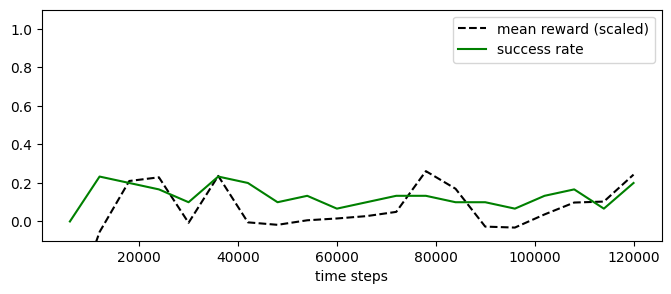

In [28]:
experiment_mappo.plot_eval_logs(reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [29]:
policy_mappo = experiment_mappo.load_policy(name='best_policy')
evaluate_policy(policy_mappo, test_venv, n_eval_episodes=30)

(-149.71470490296682, 131.72873973549812)

In [83]:
display_episode_video(test_env, policy=policy_mappo, factor=4, seed=123, **render_kwargs())

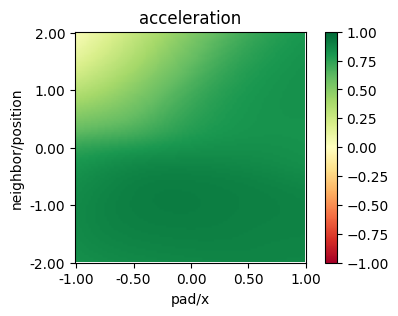

In [ ]:
plot_policy(policy_mappo, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.1, 'neighbor/velocity': 0.1},
            actions={0: 'acceleration'}, width=5, height=3)

As for PPO (see :doc:`Dummy-Continuous`), MAPPO struggles to converge towards the an optimal policy when the agents are initialized uniformly along the corridor.

## MAPPO starting from opposite sides

Let us check if it learns better (similar to PPO) when the agents are initialized on opposing sides.

In [76]:
train_env_os = get_env(action=action, observation=observation, sensors=sensors,
                       start_in_opposite_sides=True, include_success=True, 
                       init_success=False, intermediate_success=True)

In [77]:
%%skip_if $training

path = max(pathlib.Path(f'logs/{name}/MAPPO-StartFromOpposingSides').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment_mappo_os = NavgroundExperiment.reload_from_file(str(path))
experiment_mappo_os.folder_name

In [78]:
%%run_if $training

algorithm = MappoConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = False
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MAPPO-StartFromOpposingSides'
config.max_n_iters = 1
os.makedirs(config.save_folder, exist_ok=True)

experiment_mappo_os = NavgroundExperiment(
    env=train_env_os,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)

In [79]:
%%run_if $training

experiment_mappo_os.run_for(iterations=20)

mean return = -47.3065185546875: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:06<00:00, 18.34s/it]


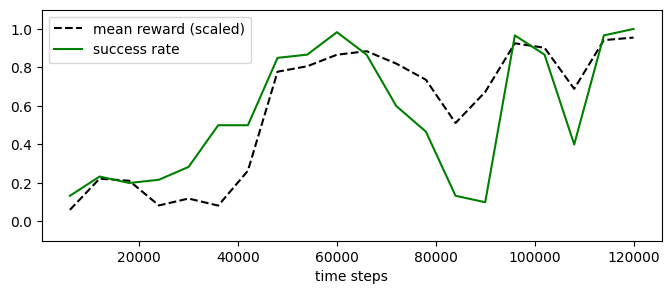

In [80]:
experiment_mappo_os.plot_eval_logs(reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [84]:
policy_mappo_os = experiment_mappo_os.load_policy(name='best_policy')
evaluate_policy(policy_mappo_os, test_venv, n_eval_episodes=30)

(-31.93338553905487, 87.03458167280833)

In [85]:
display_episode_video(test_env, policy=policy_mappo_os, factor=4, seed=123, **render_kwargs())

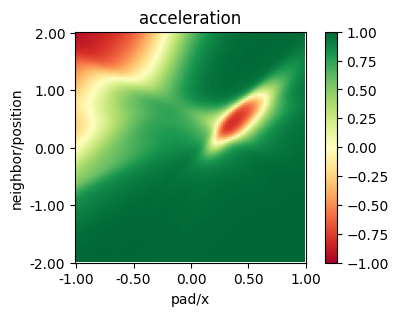

In [82]:
plot_policy(policy_mappo_os, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.1, 'neighbor/velocity': 0.1},
            actions={0: 'acceleration'}, width=5, height=3)

## MASAC with discrete actions

In [38]:
from navground.learning.config.discrete_control_action import DiscreteControlActionConfig

name = "DistributedDiscrete"

action_discrete = DiscreteControlActionConfig(use_acceleration_action=True, max_acceleration=0.1, 
                                     fix_orientation=True)
train_env_discrete = get_env(action=action_discrete, observation=observation, sensors=sensors, state=state,
                             start_in_opposite_sides=False, include_success=False)
test_env_discrete = get_env(action=action_discrete, observation=observation, sensors=sensors, state=state, 
                            start_in_opposite_sides=True, 
                            include_success=True, init_success=False, intermediate_success=True,
                            render_mode='rgb_array', render_kwargs=render_kwargs())
train_env_discrete.action_space(0)

Discrete(3)

In [39]:
%%skip_if $training

path = max(pathlib.Path(f'logs/{name}/MASAC').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment_masac_discrete = NavgroundExperiment.reload_from_file(str(path))
experiment_masac_discrete.folder_name

In [40]:
%%run_if $training

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac_discrete = NavgroundExperiment(
    env=train_env_discrete,
    eval_env=test_env_discrete,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac_discrete.folder_name

PosixPath('logs/DistributedDiscrete/MASAC/masac_navground_mlp__3694a5f2_25_05_21-12_23_48')

In [41]:
experiment_masac_discrete.run_for(iterations=40)

mean return = -13.662088394165039: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [31:41<00:00, 47.55s/it]


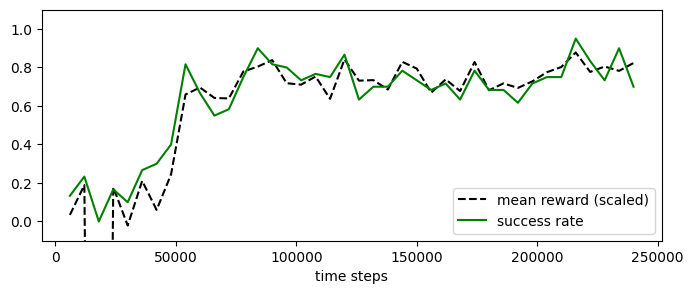

In [42]:
experiment_masac_discrete.plot_eval_logs(reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [44]:
policy_masac_discrete = experiment_masac_discrete.load_policy(name='best_policy')
test_venv_discrete = make_vec_from_penv(test_env_discrete)
evaluate_policy(policy_masac_discrete, test_venv_discrete, n_eval_episodes=30)

(-61.49761885007222, 91.95323870290115)

In [86]:
display_episode_video(test_env_discrete, policy=policy_masac_discrete, factor=4, seed=123, **render_kwargs())

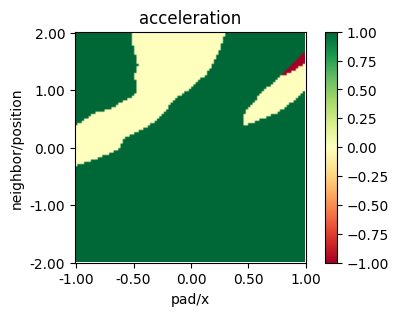

In [ ]:
plot_policy(policy_masac_discrete, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.1, 'neighbor/velocity': 0.1},
            actions={0: 'acceleration'}, width=5, height=3)